In [1]:
import sys 
sys.path.append('../scripts/')
from robot import *
from scipy.stats import multivariate_normal

In [2]:
class Particle:  ###impllikelihood
    def __init__(self, init_pose, weight):
        self.pose = init_pose
        self.weight = weight
        
    def func_state_transition(self, nu, omega, time, pose): 
        t0 = pose[2]
        if math.fabs(omega) < 1e-10:
            return pose + np.array( [nu*math.cos(t0), 
                                     nu*math.sin(t0),
                                     omega ] ) * time
        else:
            return pose + np.array( [nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)), 
                                     nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                                     omega*time ] )
        
    def motion_update(self, nu, omega, time, noise_rate_pdf): 
        ns = noise_rate_pdf.rvs()
        pnu = nu + ns[0]*math.sqrt(nu/time) + ns[1]*math.sqrt(omega/time)
        pomega = omega + ns[2]*math.sqrt(nu/time) + ns[3]*math.sqrt(omega/time)
        self.pose = self.func_state_transition(pnu, pomega, time, self.pose)
        
    def observation_update(self, observation, envmap, distance_dev_rate, direction_dev):  #変更
        for d in observation:
            obs_pos = d[0]
            obs_id = d[1]
            
            ###パーティクルの位置と地図からランドマークの距離と方角を算出###
            pos_on_map = envmap.landmarks[obs_id].pos
            particle_suggest_pos = self.relative_polar_pos(self.pose, pos_on_map)
            
            ###尤度の計算###
            distance_dev = distance_dev_rate*particle_suggest_pos[0]
            cov = np.diag(np.array([distance_dev**2, direction_dev**2]))
            self.weight *= multivariate_normal(mean=particle_suggest_pos, cov=cov).pdf(obs_pos)

    def relative_polar_pos(self, cam_pose, obj_pos): #IdealCameraからコピーしてくる
        s = math.sin(cam_pose[2])
        c = math.cos(cam_pose[2])
        relative_pos = np.array([[c,  s],
                                                   [-s, c]]).dot(obj_pos - cam_pose[0:2])
        
        distance = math.sqrt(relative_pos[0]**2 + relative_pos[1]**2)
        direction = math.atan2(relative_pos[1], relative_pos[0])
        
        return np.array([distance, direction]).T

In [3]:
class Mcl:  ###recvmapmcl
    def __init__(self, envmap, init_pose, num, motion_noise_vars, \
                 distance_dev_rate=0.14, direction_dev=0.05):    #2行目でenvmapを追加、3行目で標準偏差を追加
        self.particles = [Particle(init_pose, 1.0/num) for i in range(num)]
        self.map = envmap  #以下3行追加
        self.distance_dev_rate = distance_dev_rate
        self.direction_dev = direction_dev

        v = motion_noise_vars
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)
        
    def motion_update(self, nu, omega, time):
        for p in self.particles: p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)
            
    def observation_update(self, observation): #18行目で引数を追加
        for p in self.particles: p.observation_update(observation, self.map, \
                                                      self.distance_dev_rate, self.direction_dev) 
        
    def draw(self, ax, elems):         #次のように変更
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2])*p.weight for p in self.particles] #重みを要素にかける
        vys = [math.sin(p.pose[2])*p.weight for p in self.particles]  #重みを要素にかける
        elems.append(ax.quiver(xs, ys, vxs, vys, \
                               angles='xy', scale_units='xy', scale=1, color="blue", alpha=0.5)) #変更

In [4]:
class MclAgent(Agent):  ###recvmap (1-6行目)
    def __init__(self, time_interval, nu, omega, particle_pose, envmap, particle_num=100, \
                motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}): #2行目にenvmapを追加
        super().__init__(nu, omega)
        self.mcl = Mcl(envmap, particle_pose, particle_num, motion_noise_stds) #envmapを追加
        self.time_interval = time_interval
        
    def decision(self, observation=None):
        self.mcl.motion_update(self.nu, self.omega, self.time_interval)
        self.mcl.observation_update(observation)
        return self.nu, self.omega
        
    def draw(self, ax, elems):
        self.mcl.draw(ax, elems)

<IPython.core.display.Javascript object>


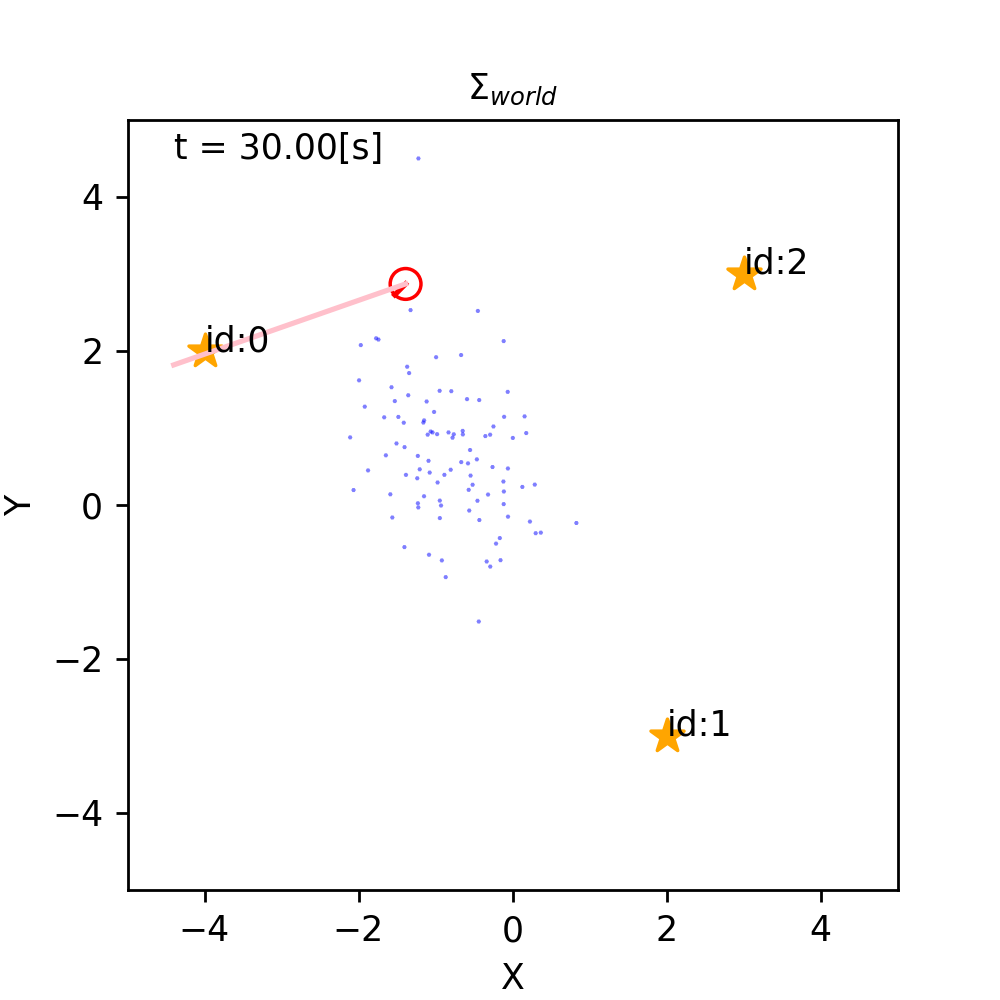

In [5]:
if __name__ == '__main__':          ###addmap （13行目のみ）
    time_interval = 0.1
    world = World(30, time_interval) 

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()                                  
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)          

    ### ロボットを作る ###
    circling = MclAgent(time_interval, 0.2, 10.0/180*math.pi, np.array([0, 0, 0]).T, m) #地図を引数で渡す
    r = Robot(np.array([0,0,0]).T, sensor=Camera(m), agent=circling, color="red")
    world.append(r)

    world.draw()                       # アニメーションさせるとき
   # r.one_step(time_interval)  # アニメーションなしでデバッグするとき